# **DỰ BÁO GIÁ CHỨNG KHOÁN**

Đoạn mã dưới đây bao gồm các bước sử dụng mô hình LSTM đơn biến để dự báo giá chứng khoán của Công ty Cổ phần Viễn thông FPT:

1. Thu thập dữ liệu từ thư viện vnstock và tiến hành tiền xử lý dữ liệu.

2. Chuẩn bị dữ liệu huấn luyện.

3. Xây dựng mô hình LSTM.

4. Tối ưu hóa tham số mô hình bằng phương pháp Bayesian.

5. Huấn luyện mô hình với tham số tối ưu.

6. Đánh giá mô hình qua các chỉ số đánh giá MSE, RMSE, MAPE, R².

7. Đánh giá kết quả thông qua biểu đồ trực quan.

#CHUẨN BỊ CÁC THƯ VIỆN

In [ ]:
!pip install vnstock
!pip install vnstock3 --upgrade
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import sys
import optuna
import seaborn as sns
np.random.seed(1)
import datetime as dt
import time
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Lấy dữ liệu từ thư viện vnstock
from vnstock import Quote


    Khi tiếp tục sử dụng Vnstock3, bạn xác nhận rằng bạn đã đọc, hiểu và đồng ý với Chính sách quyền riêng tư và Điều khoản, điều kiện về giấy phép sử dụng Vnstock3.

    Chi tiết:

    - Giấy phép sử dụng phần mềm: https://vnstocks.com/docs/tai-lieu/giay-phep-su-dung
    - Chính sách quyền riêng tư: https://vnstocks.com/docs/tai-lieu/chinh-sach-quyen-rieng-tu
    


#TIỀN XỬ LÝ DỮ LIỆU

Lấy dữ liệu

In [ ]:
# Lấy dữ liệu giá cổ phiếu FPT từ vnstock
quote = Quote(symbol="FPT", source="VCI")
start_date = "2019-11-20"
end_date = "2024-11-20"
data = quote.history(start=start_date, end=end_date)

df = pd.DataFrame(data)
print(data)


           time    open    high     low   close   volume
0    2019-11-20   24.64   24.64   23.96   24.05  2291760
1    2019-11-21   24.05   24.18   23.67   23.71  3303950
2    2019-11-22   23.84   24.18   23.50   23.71  1625820
3    2019-11-25   23.75   24.13   23.62   23.96  1087990
4    2019-11-26   24.13   24.22   24.05   24.18   968690
...         ...     ...     ...     ...     ...      ...
1247 2024-11-15  134.37  134.76  131.69  132.98  6574421
1248 2024-11-18  133.08  133.67  131.59  133.08  3910975
1249 2024-11-19  132.58  132.68  129.00  129.10  7652727
1250 2024-11-20  129.10  131.49  125.83  131.49  8474055
1251 2024-11-21  131.49  132.08  130.10  132.08  3183165

[1252 rows x 6 columns]


Xử lý dữ liệu

In [ ]:
# Chuyển đổi dữ liệu về dạng DataFrame và xử lý
if df is not None:
    df = pd.DataFrame(df)
    df.set_index('time', inplace=True)
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
else:
    raise ValueError("Không thể lấy dữ liệu từ vnstock. Vui lòng kiểm tra kết nối hoặc mã cổ phiếu.")

# Loại bỏ các hàng có volume = 0
df.drop(df[df['volume'] == 0].index, inplace=True)

In [ ]:
# Chọn biến huấn luyện
series = df['close', 'high', 'volume']

# Chia dữ liệu thành các tập Train, Validation và Test
train_data = series.loc["2019-11-20":"2022-11-20"].values.reshape(-1, 1)
val_data = series.loc["2022-11-21":"2023-11-20"].values.reshape(-1, 1)
test_data = series.loc["2023-11-21":"2024-11-20"].values.reshape(-1, 1)

# Chuẩn hoá dữ liệu
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

#XÂY DỰNG MÔ HÌNH

Xây dựng và huấn luyện mô hình trên tập train và validation

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80, verbose=1, mode='min')
callbacks_list = [earlystop]

def fit_model(train, val, timesteps, hl, lr, batch, epochs):
    X_train, Y_train, X_val, Y_val = [], [], [], []

    # Chuẩn bị dữ liệu train
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Chuẩn bị dữ liệu validation
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xây dựng mô hình
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation = 'relu', return_sequences = True))
    model.add(LSTM(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False)
    return model, history.history['loss'], history.history['val_loss']


Đánh giá và dự đoán trên tập test

In [ ]:
def evaluate_model(model, test, timesteps):
    X_test = []
    Y_test = []

    # Chuẩn bị dữ liệu test
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Dự đoán
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

Tối ưu hoá các tham số

In [ ]:
# Hàm mục tiêu để tối ưu hoá các tham số với Bayesian Optimization
def objective(trial):
    timesteps = trial.suggest_int('timesteps', 20, 60, step=10)
    hl = [trial.suggest_int(f'hl_{i}', 20, 50, step=5) for i in range(2)]
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 50, 300, step=50)

    model, train_loss, val_loss = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs)

    mse, rmse, mape, r2, _, _ = evaluate_model(model, test, timesteps)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)


[I 2025-01-04 05:14:51,575] A new study created in memory with name: no-name-31d33df4-7b14-412c-9ed7-5d1651f6373e
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2025-01-04 05:16:29,376] Trial 0 finished with value: 0.003480062240309347 and parameters: {'timesteps': 30, 'hl_0': 45, 'hl_1': 35, 'lr': 0.0007321889553119995, 'batch_size': 64, 'num_epochs': 150}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[I 2025-01-04 05:17:20,874] Trial 1 finished with value: 0.06342190743362465 and parameters: {'timesteps': 20, 'hl_0': 35, 'hl_1': 20, 'lr': 0.0006439569570480634, 'batch_size': 64, 'num_epochs': 150}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


[I 2025-01-04 05:18:14,221] Trial 2 finished with value: 0.051308733379863664 and parameters: {'timesteps': 20, 'hl_0': 30, 'hl_1': 40, 'lr': 0.0018072867902391018, 'batch_size': 64, 'num_epochs': 150}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


[I 2025-01-04 05:20:11,406] Trial 3 finished with value: 1.8976018354988267 and parameters: {'timesteps': 20, 'hl_0': 50, 'hl_1': 50, 'lr': 0.00630356865585419, 'batch_size': 16, 'num_epochs': 100}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


[I 2025-01-04 05:20:53,995] Trial 4 finished with value: 0.6824235428390082 and parameters: {'timesteps': 30, 'hl_0': 40, 'hl_1': 50, 'lr': 0.00013803750493347332, 'batch_size': 32, 'num_epochs': 50}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


[I 2025-01-04 05:25:09,111] Trial 5 finished with value: 2.391807795479248 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 45, 'lr': 0.0059661044662861025, 'batch_size': 32, 'num_epochs': 200}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2025-01-04 05:25:57,207] Trial 6 finished with value: 23.427190301854974 and parameters: {'timesteps': 20, 'hl_0': 40, 'hl_1': 50, 'lr': 0.00015129836930656307, 'batch_size': 128, 'num_epochs': 150}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-01-04 05:36:23,269] Trial 7 finished with value: 9.426399751249324 and parameters: {'timesteps': 60, 'hl_0': 25, 'hl_1': 45, 'lr': 0.00012019457772331441, 'batch_size': 16, 'num_epochs': 250}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


[I 2025-01-04 05:37:13,024] Trial 8 finished with value: 0.06939190170055883 and parameters: {'timesteps': 20, 'hl_0': 45, 'hl_1': 50, 'lr': 0.0032536104009603817, 'batch_size': 128, 'num_epochs': 150}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-01-04 05:38:16,037] Trial 9 finished with value: 197.0610676515639 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 25, 'lr': 0.00048156362383603075, 'batch_size': 128, 'num_epochs': 100}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2025-01-04 05:41:11,301] Trial 10 finished with value: 114.19578055987405 and parameters: {'timesteps': 40, 'hl_0': 20, 'hl_1': 30, 'lr': 0.0003518564872058367, 'batch_size': 64, 'num_epochs': 300}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


[I 2025-01-04 05:42:57,769] Trial 11 finished with value: 9.061703256894326 and parameters: {'timesteps': 30, 'hl_0': 30, 'hl_1': 35, 'lr': 0.0018500082350473093, 'batch_size': 64, 'num_epochs': 200}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-04 05:43:54,663] Trial 12 finished with value: 0.04338407859598122 and parameters: {'timesteps': 30, 'hl_0': 30, 'hl_1': 40, 'lr': 0.001347711584305533, 'batch_size': 64, 'num_epochs': 100}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-01-04 05:44:27,915] Trial 13 finished with value: 4.562185271501874 and parameters: {'timesteps': 30, 'hl_0': 35, 'hl_1': 35, 'lr': 0.0011011791078141756, 'batch_size': 64, 'num_epochs': 50}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-01-04 05:45:32,376] Trial 14 finished with value: 0.009957145276636404 and parameters: {'timesteps': 40, 'hl_0': 30, 'hl_1': 40, 'lr': 0.0010176723517798232, 'batch_size': 64, 'num_epochs': 100}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-01-04 05:46:39,467] Trial 15 finished with value: 29.6703908545044 and parameters: {'timesteps': 40, 'hl_0': 50, 'hl_1': 30, 'lr': 0.00028284858591795905, 'batch_size': 64, 'num_epochs': 100}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


[I 2025-01-04 05:49:28,281] Trial 16 finished with value: 0.11146341406059125 and parameters: {'timesteps': 50, 'hl_0': 20, 'hl_1': 40, 'lr': 0.0007712146310856886, 'batch_size': 64, 'num_epochs': 250}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2025-01-04 05:50:59,235] Trial 17 finished with value: 0.871378036322431 and parameters: {'timesteps': 40, 'hl_0': 40, 'hl_1': 30, 'lr': 0.0034065489083724525, 'batch_size': 16, 'num_epochs': 50}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


[I 2025-01-04 05:54:35,110] Trial 18 finished with value: 0.48881666945429897 and parameters: {'timesteps': 40, 'hl_0': 25, 'hl_1': 35, 'lr': 0.00024850579747345456, 'batch_size': 32, 'num_epochs': 200}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-01-04 05:55:50,851] Trial 19 finished with value: 0.01084847050036852 and parameters: {'timesteps': 60, 'hl_0': 25, 'hl_1': 45, 'lr': 0.0005442298054187958, 'batch_size': 64, 'num_epochs': 100}. Best is trial 0 with value: 0.003480062240309347.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


[I 2025-01-04 05:58:06,211] Trial 20 finished with value: 0.0027612273627968488 and parameters: {'timesteps': 30, 'hl_0': 35, 'hl_1': 25, 'lr': 0.003275742243647281, 'batch_size': 64, 'num_epochs': 250}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-01-04 06:00:39,590] Trial 21 finished with value: 0.04904765753181855 and parameters: {'timesteps': 30, 'hl_0': 35, 'hl_1': 20, 'lr': 0.00988271681551776, 'batch_size': 64, 'num_epochs': 300}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


[I 2025-01-04 06:02:52,820] Trial 22 finished with value: 0.057939430793543086 and parameters: {'timesteps': 30, 'hl_0': 30, 'hl_1': 25, 'lr': 0.0029131517137892886, 'batch_size': 64, 'num_epochs': 250}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2025-01-04 06:04:57,663] Trial 23 finished with value: 0.33738508676686674 and parameters: {'timesteps': 40, 'hl_0': 40, 'hl_1': 25, 'lr': 0.0019694929147376396, 'batch_size': 64, 'num_epochs': 200}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-01-04 06:07:16,106] Trial 24 finished with value: 0.10619548842941465 and parameters: {'timesteps': 30, 'hl_0': 35, 'hl_1': 40, 'lr': 0.0009513761108783267, 'batch_size': 64, 'num_epochs': 250}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2025-01-04 06:08:56,454] Trial 25 finished with value: 0.45554820713969485 and parameters: {'timesteps': 50, 'hl_0': 30, 'hl_1': 35, 'lr': 0.0014496103852782013, 'batch_size': 64, 'num_epochs': 150}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-01-04 06:14:22,977] Trial 26 finished with value: 0.07945212065153509 and parameters: {'timesteps': 40, 'hl_0': 45, 'hl_1': 30, 'lr': 0.00043312880178212514, 'batch_size': 32, 'num_epochs': 300}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


[I 2025-01-04 06:18:39,885] Trial 27 finished with value: 0.32950321267156946 and parameters: {'timesteps': 30, 'hl_0': 40, 'hl_1': 25, 'lr': 0.002507622073355545, 'batch_size': 16, 'num_epochs': 200}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-01-04 06:19:11,513] Trial 28 finished with value: 0.00949739595884363 and parameters: {'timesteps': 30, 'hl_0': 25, 'hl_1': 20, 'lr': 0.004824908463524093, 'batch_size': 128, 'num_epochs': 100}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


[I 2025-01-04 06:19:45,963] Trial 29 finished with value: 0.025951340058483888 and parameters: {'timesteps': 20, 'hl_0': 25, 'hl_1': 20, 'lr': 0.004759705705537523, 'batch_size': 128, 'num_epochs': 150}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-01-04 06:20:40,978] Trial 30 finished with value: 0.1374063737728807 and parameters: {'timesteps': 30, 'hl_0': 50, 'hl_1': 20, 'lr': 0.008213067231307627, 'batch_size': 128, 'num_epochs': 150}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2025-01-04 06:21:16,368] Trial 31 finished with value: 0.2587012979097951 and parameters: {'timesteps': 30, 'hl_0': 35, 'hl_1': 20, 'lr': 0.000749015118048939, 'batch_size': 128, 'num_epochs': 100}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2025-01-04 06:21:36,682] Trial 32 finished with value: 0.007746459219379783 and parameters: {'timesteps': 40, 'hl_0': 25, 'hl_1': 25, 'lr': 0.0037479988912913847, 'batch_size': 128, 'num_epochs': 50}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-01-04 06:21:51,622] Trial 33 finished with value: 0.011316889096463358 and parameters: {'timesteps': 20, 'hl_0': 20, 'hl_1': 25, 'lr': 0.00426662112345965, 'batch_size': 128, 'num_epochs': 50}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-01-04 06:22:06,769] Trial 34 finished with value: 0.05987540726977416 and parameters: {'timesteps': 20, 'hl_0': 25, 'hl_1': 20, 'lr': 0.005711404729614791, 'batch_size': 128, 'num_epochs': 50}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-01-04 06:22:25,968] Trial 35 finished with value: 0.8506355385677586 and parameters: {'timesteps': 40, 'hl_0': 20, 'hl_1': 25, 'lr': 0.004300585544643887, 'batch_size': 128, 'num_epochs': 50}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-01-04 06:23:00,071] Trial 36 finished with value: 0.16765111040952968 and parameters: {'timesteps': 30, 'hl_0': 25, 'hl_1': 30, 'lr': 0.0077851513837991935, 'batch_size': 128, 'num_epochs': 100}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-01-04 06:24:30,477] Trial 37 finished with value: 0.041030195210361414 and parameters: {'timesteps': 20, 'hl_0': 35, 'hl_1': 20, 'lr': 0.002345389815145838, 'batch_size': 32, 'num_epochs': 150}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2025-01-04 06:24:51,889] Trial 38 finished with value: 0.043770611119325314 and parameters: {'timesteps': 30, 'hl_0': 50, 'hl_1': 25, 'lr': 0.0015187168414295754, 'batch_size': 128, 'num_epochs': 50}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2025-01-04 06:30:22,297] Trial 39 finished with value: 2.1261113415323174 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 30, 'lr': 0.005579699186982575, 'batch_size': 16, 'num_epochs': 150}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-01-04 06:30:48,060] Trial 40 finished with value: 0.05547399295115352 and parameters: {'timesteps': 20, 'hl_0': 30, 'hl_1': 20, 'lr': 0.003360515790216372, 'batch_size': 128, 'num_epochs': 100}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-01-04 06:31:53,128] Trial 41 finished with value: 1.1835680867411862 and parameters: {'timesteps': 40, 'hl_0': 30, 'hl_1': 40, 'lr': 0.0006435718019136104, 'batch_size': 64, 'num_epochs': 100}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2025-01-04 06:32:56,829] Trial 42 finished with value: 0.18950954402377235 and parameters: {'timesteps': 40, 'hl_0': 30, 'hl_1': 40, 'lr': 0.0010277922869097289, 'batch_size': 64, 'num_epochs': 100}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-04 06:33:32,976] Trial 43 finished with value: 0.008361158665362507 and parameters: {'timesteps': 50, 'hl_0': 25, 'hl_1': 45, 'lr': 0.002312700837683036, 'batch_size': 64, 'num_epochs': 50}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-04 06:34:04,276] Trial 44 finished with value: 0.0500426520626416 and parameters: {'timesteps': 50, 'hl_0': 25, 'hl_1': 45, 'lr': 0.003878334213299099, 'batch_size': 128, 'num_epochs': 50}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-01-04 06:34:44,311] Trial 45 finished with value: 0.02389179658983305 and parameters: {'timesteps': 60, 'hl_0': 20, 'hl_1': 45, 'lr': 0.002111774354375029, 'batch_size': 64, 'num_epochs': 50}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-04 06:35:49,572] Trial 46 finished with value: 0.21581113596159746 and parameters: {'timesteps': 50, 'hl_0': 25, 'hl_1': 50, 'lr': 0.0027364880693603938, 'batch_size': 32, 'num_epochs': 50}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-01-04 06:37:36,640] Trial 47 finished with value: 0.032235286563141584 and parameters: {'timesteps': 30, 'hl_0': 25, 'hl_1': 35, 'lr': 0.006433209771735853, 'batch_size': 64, 'num_epochs': 200}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-01-04 06:41:47,793] Trial 48 finished with value: 0.22803818009205912 and parameters: {'timesteps': 60, 'hl_0': 40, 'hl_1': 25, 'lr': 0.0016288390969147275, 'batch_size': 16, 'num_epochs': 100}. Best is trial 20 with value: 0.0027612273627968488.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-01-04 06:42:22,226] Trial 49 finished with value: 0.007340300279752064 and parameters: {'timesteps': 40, 'hl_0': 20, 'hl_1': 25, 'lr': 0.005117264421051969, 'batch_size': 64, 'num_epochs': 50}. Best is trial 20 with value: 0.0027612273627968488.


Best params: {'timesteps': 30, 'hl_0': 35, 'hl_1': 25, 'lr': 0.003275742243647281, 'batch_size': 64, 'num_epochs': 250}


Huấn luyện mô hình với tham số tối ưu

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


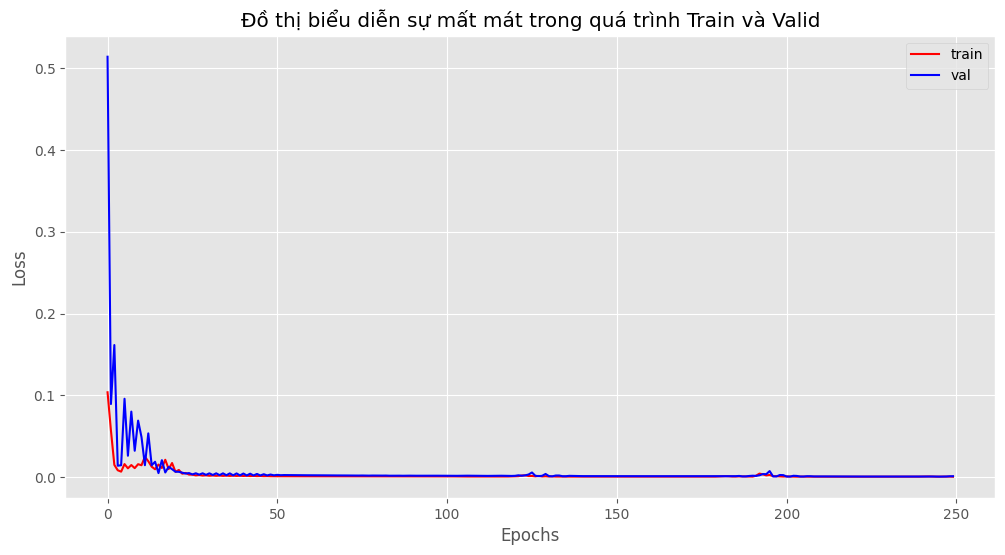

In [ ]:
timesteps = 30
hl = [35,25]
lr =  0.003275742243647281
batch_size = 64
num_epochs = 250

model, train_error, val_error = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs)

# Đồ thị biểu diễn sự mất mát trong quá trình huấn luyện và kiểm tra
def plot_error(train_loss, val_loss):
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Đồ thị biểu diễn sự mất mát trong quá trình Train và Valid')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()
plot_error(train_error, val_error)

#ĐÁNH GIÁ KẾT QUẢ

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
MSE = 0.008631625924682858
RMSE = 0.09290654403583667
MAPE = 0.04327379946607584
R-Squared Score = 0.9331965352394906


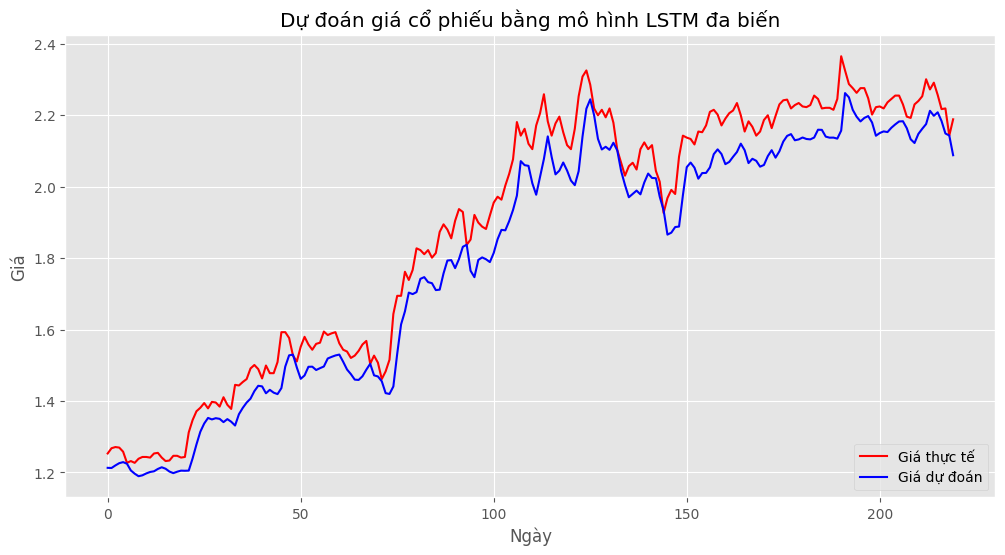

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model(model, test, timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

def plot_data(Y_test, Y_hat):
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test, color='r', label='Giá thực tế')
    plt.plot(Y_hat, color='b', label='Giá dự đoán')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
    plt.title("Dự đoán giá cổ phiếu bằng mô hình LSTM đa biến")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
plot_data(true, predicted)

In [ ]:
# Tạo DataFrame từ giá trị thực tế và giá trị dự đoán
result_df = pd.DataFrame({
    'Actual': true.flatten(),
    'Predicted': predicted.flatten()
})

result_df['Giá thực tế'] = sc.inverse_transform(result_df[['Actual']])
result_df['Giá dự đoán'] = sc.inverse_transform(result_df[['Predicted']])
result_df['Chênh lệch'] = result_df['Giá thực tế'] - result_df['Giá dự đoán']
result_df = result_df.drop(columns=['Actual', 'Predicted'])

print("Bảng so sánh giá trị thực tế và dự đoán (Đơn vị: nghìn đồng):")
print(result_df.head(16))

Bảng so sánh giá trị thực tế và dự đoán (Đơn vị: nghìn đồng):
    Giá thực tế  Giá dự đoán  Chênh lệch
0         82.59    80.488579    2.101421
1         83.36    80.465775    2.894225
2         83.53    80.842026    2.687974
3         83.45    81.171661    2.278339
4         82.85    81.324219    1.525781
5         81.22    81.088089    0.131911
6         81.48    80.106255    1.373745
7         81.22    79.632454    1.587546
8         81.82    79.261604    2.558396
9         82.08    79.394814    2.685186
10        82.08    79.671021    2.408979
11        81.99    79.884628    2.105372
12        82.59    79.982033    2.607967
13        82.68    80.326660    2.353340
14        81.99    80.572182    1.417818
15        81.48    80.359230    1.120770
